## Examples of fitting trees and forests

In this notebook we step through the basics of learning trees and random forests. This will hopefully be of help as you begin Assignment 3. 

First we build a classification tree on the Titanic data. Then we fit random forests for regression on the California housing data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
titanic_train = pd.read_csv('https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/train.csv')
titanic_test = pd.read_csv('https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/test.csv')
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Preprocess the data

We'll start by dropping categorical variables having many values; these are likely to just lead to overfitting, and will dramatically increase the number of features if they are converted to dummies. 


In [3]:
dat = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
dat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Next, we'll drop rows that have missing values.

In [4]:
dat = dat.dropna()
dat

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


That's it! Now we just separate out `Survived` as the labels we wish to predict.


In [5]:
from sklearn.preprocessing import LabelEncoder
encoded_data = pd.get_dummies(dat)
encoded_data.head()
X = encoded_data.drop('Survived', axis=1)
y = encoded_data['Survived']
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,1,0,0,1,0
886,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0


In [6]:
X = X.drop('Sex_male', axis=1)
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1
4,3,35.0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,1,0,1,0
886,2,27.0,0,0,13.0000,0,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,1
889,1,26.0,0,0,30.0000,0,1,0,0


## Grow a classification tree

Here's how we fit a classification tree using the `DecisionTreeClassifier` function from `scikit-learn`.
We can then visualize the tree using the built-in function `plot_tree`. To keep the tree relatively small and interpretable, we stop splitting a node if the number of data points becomes too small.


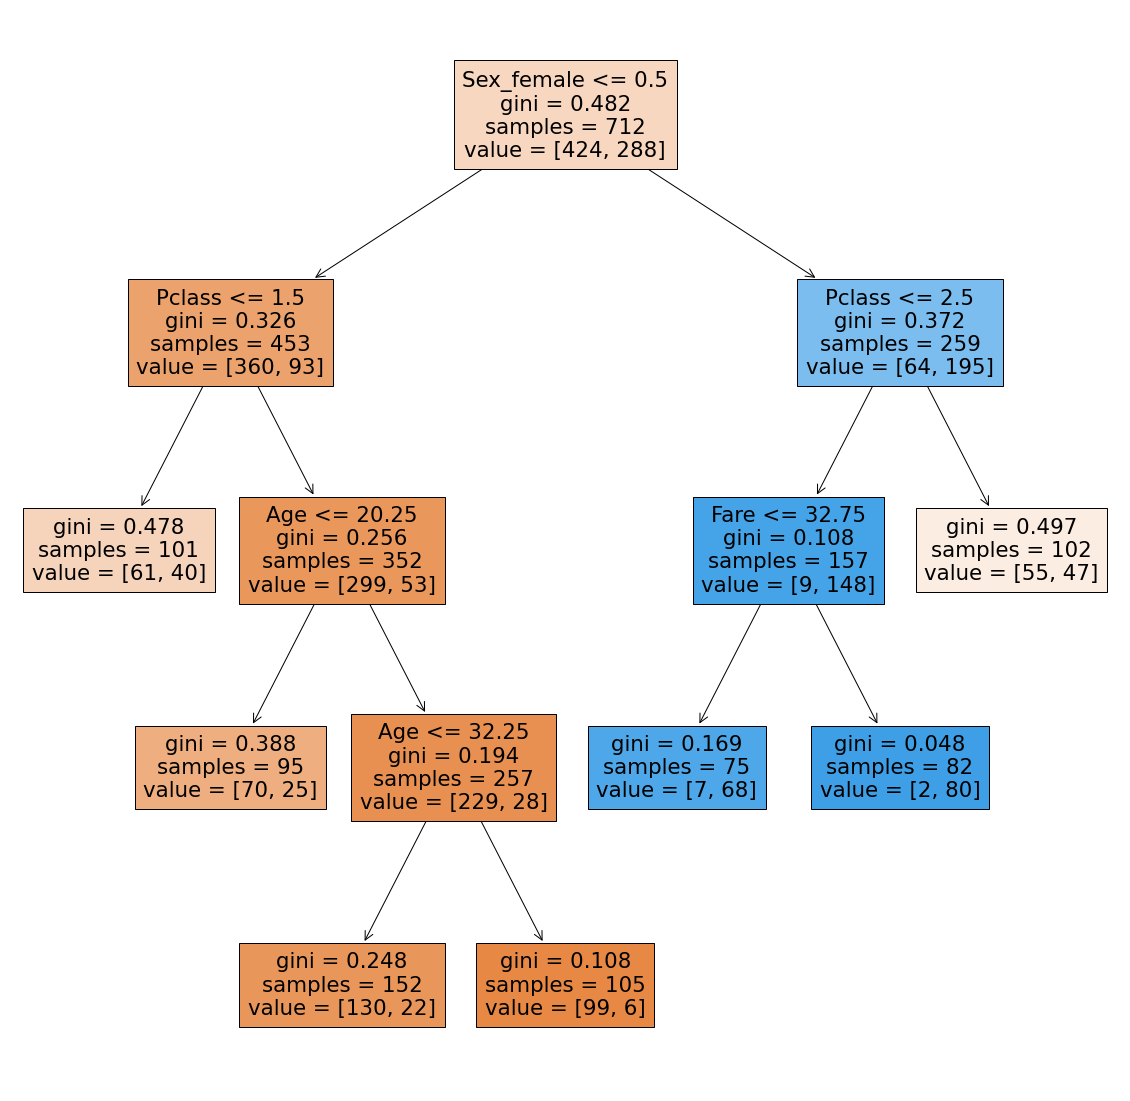

In [7]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier(min_samples_leaf=75)
dtree = dtree.fit(X, y)
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(dtree, filled=True, feature_names = X.columns)

## Growing a forest of trees

Nex, we'll build an ensemble of trees using random forests. We'll look at the "out of bag" (OOB) error as we increase the number of trees in the ensemble.


In [8]:
from sklearn import ensemble
from tqdm import tqdm

rf = ensemble.RandomForestClassifier(min_samples_leaf=1, max_features=5, oob_score=True)
oob_error = []
num_trees = np.arange(20, 500, 10)

for m in tqdm(num_trees):
    rf.set_params(n_estimators=m)
    model = rf.fit(X, y)
    oob_error.append(1-model.oob_score_)


100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


Text(0.5, 0, 'Number of trees')

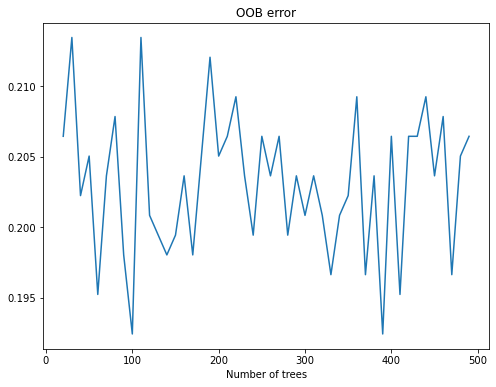

In [9]:
plt.figure(figsize=(8,6))
plt.plot(num_trees, oob_error)
plt.title('OOB error')
plt.xlabel('Number of trees')

## Seeing the forest for the trees

To visualize the model, we look at variable importance, which is the improvement in the loss (Gini index) due to splitting on a given variable, averaged over all of the trees in the forest.


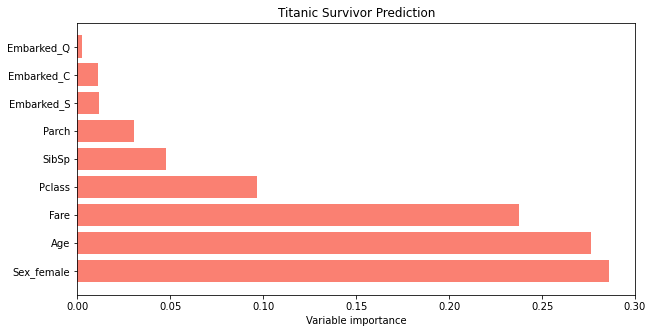

In [10]:
rf.set_params(n_estimators=100)
model = rf.fit(X, y)
fig, ax = plt.subplots(figsize=(10,5))
inds = np.argsort(model.feature_importances_)
inds = np.flip(inds)
ax.barh(np.arange(9), model.feature_importances_[inds], color='salmon')
ax.set_yticks(np.arange(9))
_ = ax.set_yticklabels(X.columns[inds])
_ = ax.set_xlabel('Variable importance')
_ = ax.set_title('Titanic Survivor Prediction')


We find that the most important variables are `Age`, `Fare` and `Sex`. This matches the popular conception of the Titanic disaster (as continued in the popular film starring Leonardo DiCaprio and Kate Winslet), which holds that women, children, and wealthy passengers were given priority for access to the lifeboats.


## [California Learning](https://www.youtube.com/watch?v=N-aK6JnyFmk) 
*(On such a winter's day)*

Next we'll fit regression forests on the California housing data. This is similar to what you are asked to do 
on Assignment 3, where you will be using data from [Zillow](https://www.zillow.com/zestimate/). By their own account, "Zillow publishes Zestimate home valuations for 97.5 million homes across the country, and uses millions of statistical and machine learning models that can examine hundreds of data points for each individual home."

The Zillow data are richer and will require more care; the California data are simple and clean. But this will illustrate the concepts and help get you started.


In [11]:
from sklearn.datasets import fetch_california_housing
ca_housing = fetch_california_housing()
print(ca_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [12]:
california = pd.DataFrame(ca_housing.data, columns=ca_housing.feature_names)
california['MedValue'] = ca_housing.target
california.head()
california.shape

(20640, 9)

## Now fit a sequence of regression forests

The data are good to go. Now we fit a sequence of regression forests, using an increasing number of trees.
We track the performance using the OOB error. 


In [13]:
cali = california.head(5000)
X = cali.drop('MedValue', axis=1)
y = cali['MedValue']

oob_error = []
num_trees = np.arange(50, 180, 20)
rf = ensemble.RandomForestRegressor(min_samples_leaf=100, max_features=4, \
                                    criterion='mse', oob_score=True)

for m in tqdm(num_trees):
    rf.set_params(n_estimators=m)
    model = rf.fit(X, y)
    oob_error.append(1-model.oob_score_)


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


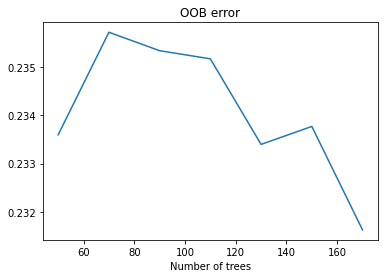

In [14]:
plt.plot(num_trees, oob_error)
plt.title('OOB error')
_ = plt.xlabel('Number of trees')

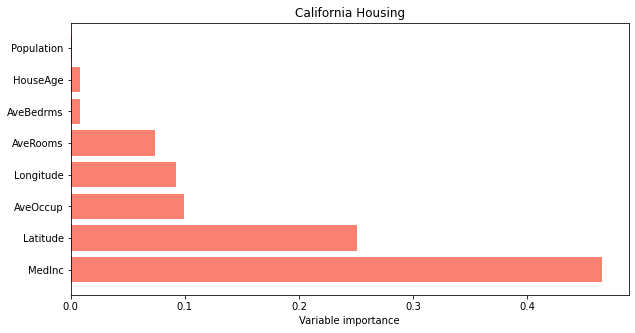

In [15]:
rf.set_params(n_estimators=50)
model = rf.fit(X,y)

p = X.shape[1]
fig, ax = plt.subplots(figsize=(10,5))
inds = np.argsort(model.feature_importances_)
inds = np.flip(inds)
ax.barh(np.arange(p), model.feature_importances_[inds], color='salmon')
ax.set_yticks(np.arange(p))
_ = ax.set_yticklabels(X.columns[inds])
_ = ax.set_xlabel('Variable importance')
_ = ax.set_title('California Housing')

## Location, location, ... income


When we view the most important features, we're reminded of old aphorism that the three most important factors in real estate are (1) location (2) location (3) location.  Especially since `MedInc` is strongly correlated with location.



## Your turn!

Assignment 3 will give you ample practice with these ideas and the associated Python code. Have fun!
